In [1]:
import pandas as pd
import seaborn as sns

from collections import Counter
from wordcloud import WordCloud
from pandarallel import pandarallel
from matplotlib import pyplot as plt

from reviews.config import processed_data_dir
from reviews.utils import flat_sentence_tokens, preprocess_df, find_tokens_df

pandarallel.initialize(progress_bar=False, nb_workers=8)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Prepare Data

In [2]:
# read data
reviews_df = pd.read_json(
    processed_data_dir / "products_reviews.json.gz", orient="records"
)

reviews_df["summary"] = reviews_df["summary"].astype("string")
reviews_df["text"] = reviews_df["text"].astype("string")

reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21951 entries, 0 to 21950
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   asin             21951 non-null  object        
 1   overall          21951 non-null  int64         
 2   summary          21951 non-null  string        
 3   text             21951 non-null  string        
 4   timestamp        21951 non-null  datetime64[ns]
 5   vote             21951 non-null  int64         
 6   brand            21951 non-null  object        
 7   category         21951 non-null  object        
 8   description      21447 non-null  object        
 9   imageURLHighRes  18036 non-null  object        
 10  price            21951 non-null  float64       
 11  title            21951 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(6), string(2)
memory usage: 2.2+ MB


In [3]:
def tokens_counters(tokens_raw, tokens_lemma, tokens_stem):
    # flat sentence tokens
    tokens_raw = flat_sentence_tokens(tokens_raw)
    tokens_lemma = flat_sentence_tokens(tokens_lemma)
    tokens_stem = flat_sentence_tokens(tokens_stem)

    # counters
    c_raw = Counter(tokens_raw)
    c_lemma = Counter(tokens_lemma)
    c_stem = Counter(tokens_stem)

    return {
        "Raw": c_raw,
        "Lemmatization": c_lemma,
        "Stemming": c_stem,
    }

In [4]:
def plot_tokens(counters_dict):
    fig, ax = plt.subplots(1, 3, figsize=(20, 8), sharex="all")
    for i, (title, counter) in enumerate(counters_dict.items()):
        data = pd.DataFrame(counter.most_common(30))

        data[1] = data[1] / sum(counter.values())

        sns.barplot(y=data[0], x=data[1], ax=ax[i])

        ax[i].set_title(title)
        ax[i].set_ylabel("Tokens")
        ax[i].set_xlabel("Frequency")

    fig.tight_layout()

In [5]:
def plot_tokens_wordcloud(counters_dict):
    fig, ax = plt.subplots(1, 3, figsize=(20, 8))
    for i, (title, counter) in enumerate(counters_dict.items()):
        wc = WordCloud(
            collocations=False,
            prefer_horizontal=0.6,
            width=800,
            height=400,
            background_color="white",
        )
        wc.fit_words(counter)

        ax[i].imshow(wc.to_image())
        ax[i].set_title(title)
        ax[i].grid(False)
        ax[i].axis("off")

    fig.tight_layout()

# Summary Tokens

In [6]:
summary_raw = preprocess_df(reviews_df, field="summary")

4421 rare words found of which 8 are seeds.
0 common words found of which 0 are seeds.
Common: set()
Empty Docs: 1.98%


In [7]:
summary_lemma = preprocess_df(
    reviews_df, field="summary", normalize="lemmatization", out_dir=processed_data_dir, **dict(t1=0.9, t2=4),
)

3772 rare words found of which 7 are seeds.
1 common words found of which 0 are seeds.
Common: {'star'}
Empty Docs: 24.78%


In [8]:
summary_stem = preprocess_df(
    reviews_df, field="summary", normalize="stemming", out_dir=processed_data_dir, **dict(t1=0.9, t2=4),
)

3258 rare words found of which 8 are seeds.
1 common words found of which 0 are seeds.
Common: {'star'}
Empty Docs: 24.53%


In [9]:
summary_counters = tokens_counters(
    summary_raw["tokens"], summary_lemma["tokens"], summary_stem["tokens"]
)

for (title, counter) in summary_counters.items():
    print(f"{title} Tokens:", len(counter.items()))

Raw Tokens: 1616
Lemmatization Tokens: 1419
Stemming Tokens: 1376


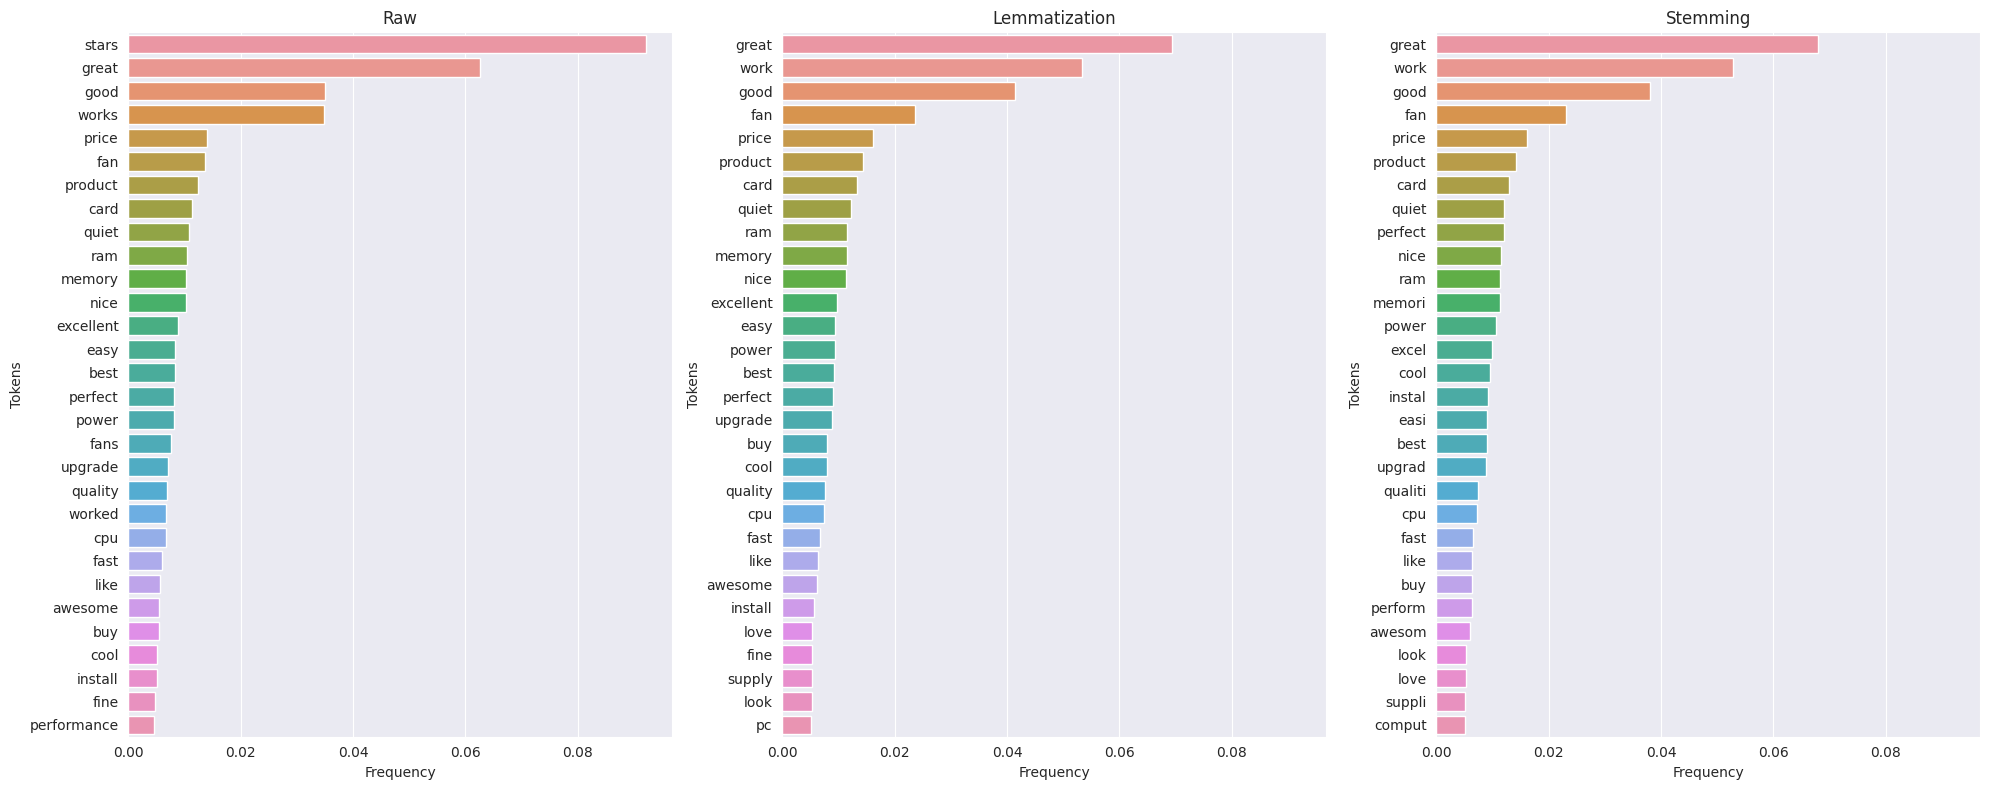

In [10]:
plot_tokens(summary_counters)

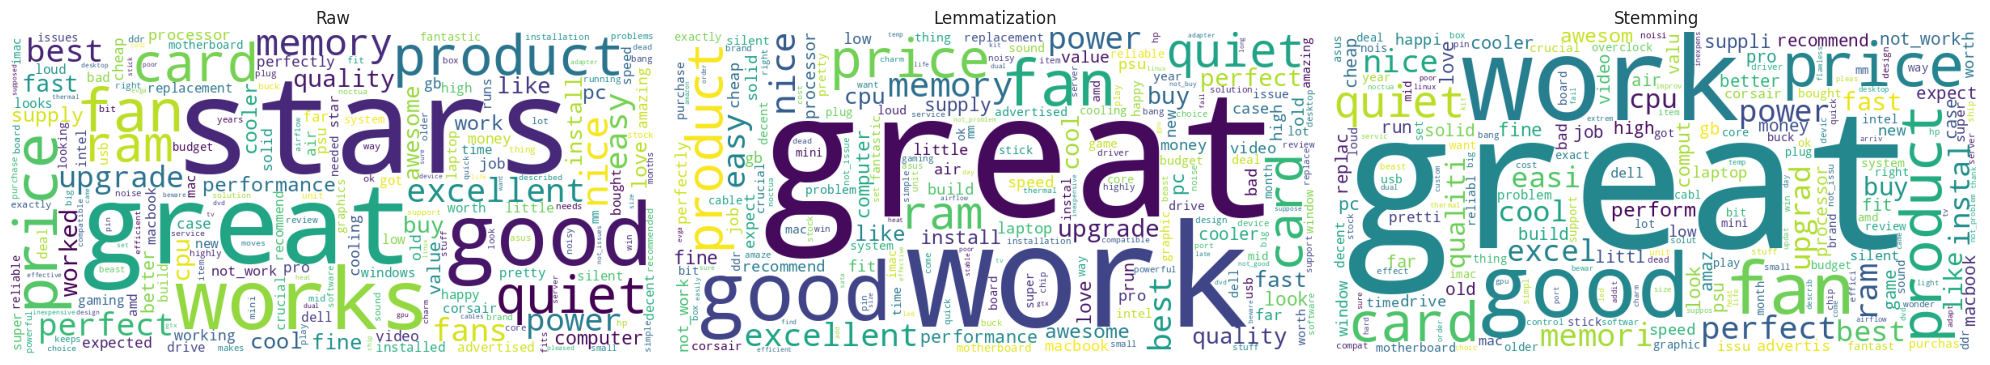

In [11]:
plot_tokens_wordcloud(summary_counters)

# Text Tokens

In [12]:
text_raw = preprocess_df(reviews_df, field="text")

16072 rare words found of which 0 are seeds.
0 common words found of which 0 are seeds.
Common: set()
Empty Docs: 0.12%


In [13]:
text_lemma = preprocess_df(
    reviews_df, field="text", normalize="lemmatization", out_dir=processed_data_dir, **dict(t1=0.9, t2=4),
)

13365 rare words found of which 0 are seeds.
0 common words found of which 0 are seeds.
Common: set()
Empty Docs: 0.20%


In [14]:
text_stem = preprocess_df(
    reviews_df, field="text", normalize="stemming", out_dir=processed_data_dir, **dict(t1=0.9, t2=4),
)

10606 rare words found of which 0 are seeds.
0 common words found of which 0 are seeds.
Common: set()
Empty Docs: 0.19%


In [15]:
text_counters = tokens_counters(
    text_raw["tokens"], text_lemma["tokens"], text_stem["tokens"]
)

for (title, counter) in text_counters.items():
    print(f"{title} Tokens:", len(counter.items()))

Raw Tokens: 8498
Lemmatization Tokens: 6777
Stemming Tokens: 6063


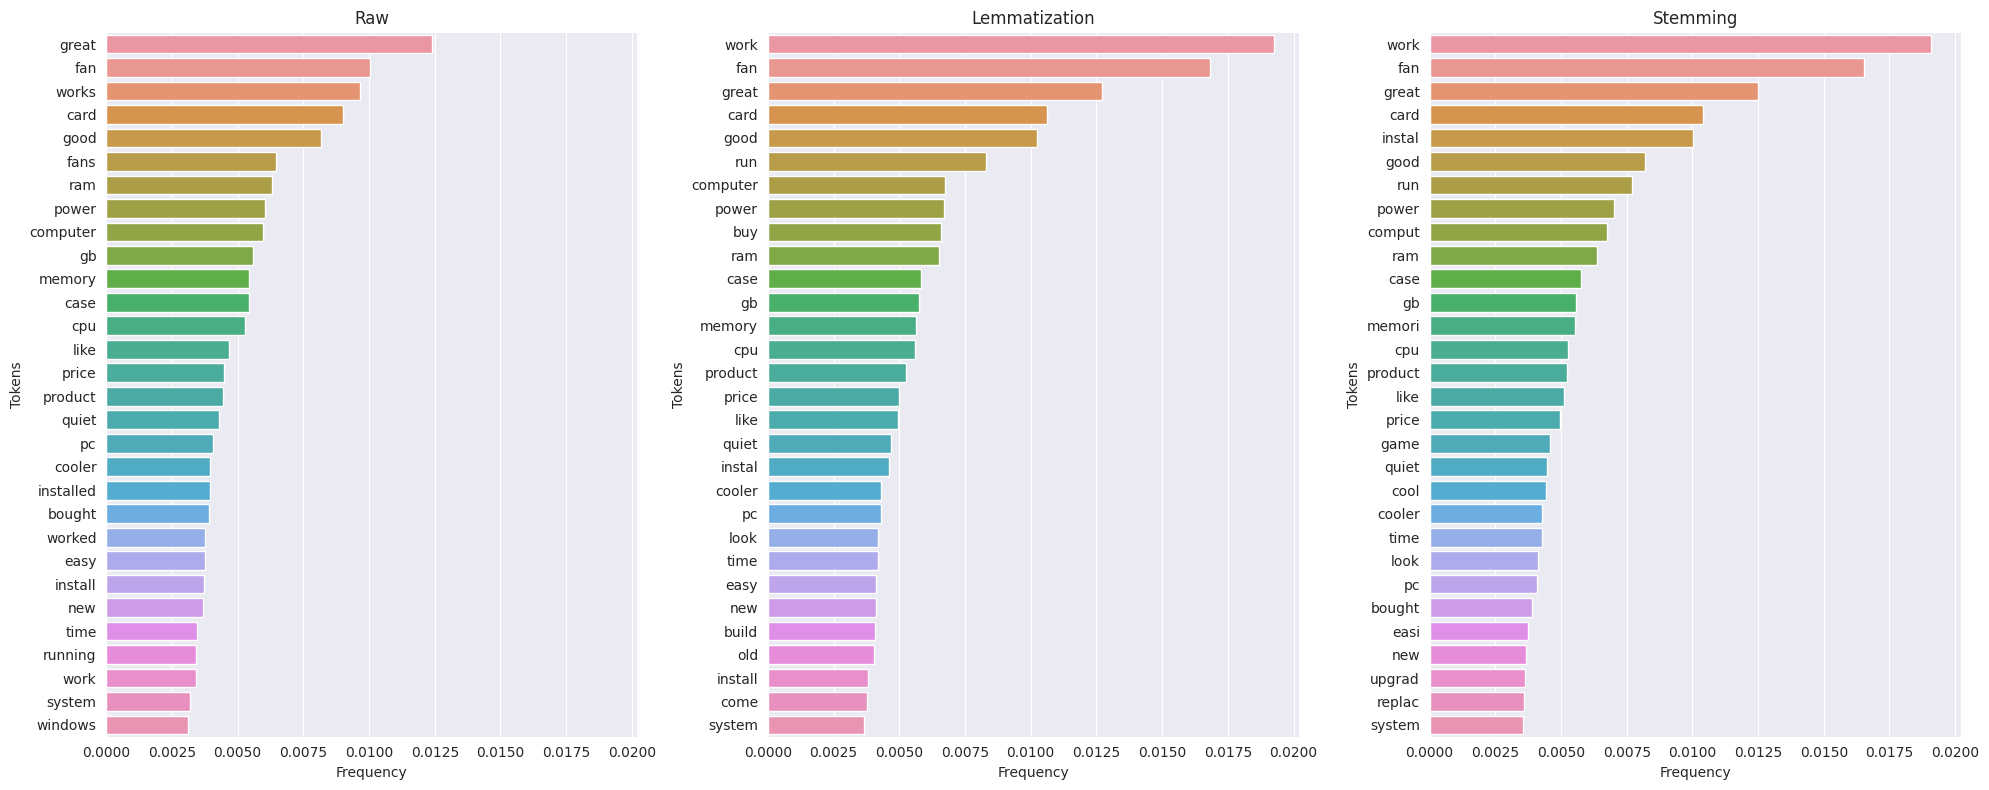

In [16]:
plot_tokens(text_counters)

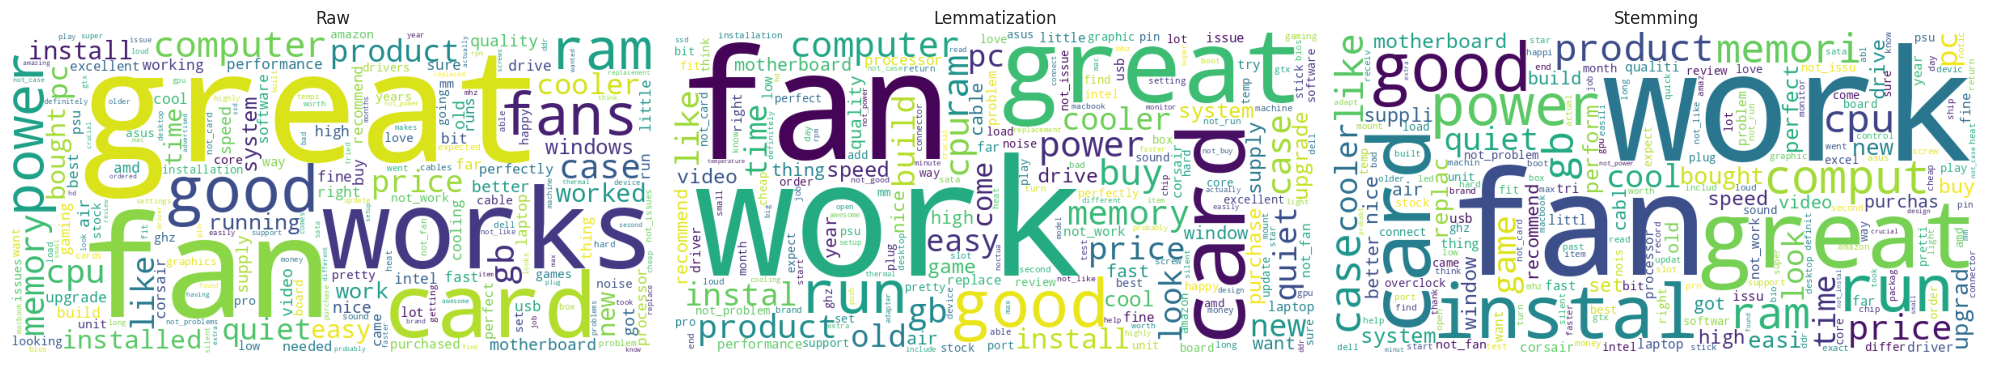

In [17]:
plot_tokens_wordcloud(text_counters)

# Tokens Analysis


In [18]:
def tokens_statistics(tokens):
    from itertools import chain

    n_sentences = tokens.apply(len)
    n_tokens = tokens.apply(lambda x: list(chain.from_iterable(x))).apply(len)

    one_token = tokens[n_tokens == 1].apply(lambda x: list(chain.from_iterable(x)))
    most_common_one_tokens = Counter([y for x in one_token for y in x]).most_common(10)

    print(f"[Sentences] Min: {n_sentences.min()}, Mean: {n_sentences.mean():.2f}, Max: {n_sentences.max()}")
    print(f"[Tokens] Min: {n_tokens.min()}, Mean: {n_tokens.mean():.2f}, Max: {n_tokens.max()}")
    print("")

    print(f"#Reviews with 0 tokens: {len(n_tokens[n_tokens == 0])} ({len(n_tokens[n_tokens == 0]) / len(n_tokens) * 100:.0f}%)")
    print(f"#Reviews with 1 token: {len(n_tokens[n_tokens == 1])} ({len(n_tokens[n_tokens == 1]) / len(n_tokens) * 100:.0f}%)")
    print("Most Common 1 Token:", set(map(lambda x: x[0], most_common_one_tokens)))

In [19]:
tokens_statistics(text_lemma["tokens"])

[Sentences] Min: 0, Mean: 3.63, Max: 167
[Tokens] Min: 0, Mean: 21.30, Max: 1730

#Reviews with 0 tokens: 43 (0%)
#Reviews with 1 token: 1136 (5%)
Most Common 1 Token: {'job', 'ok', 'excellent', 'nice', 'expect', 'thank', 'good', 'work', 'great', 'perfect'}


In [20]:
tokens_statistics(text_stem["tokens"])

[Sentences] Min: 0, Mean: 3.64, Max: 167
[Tokens] Min: 0, Mean: 21.70, Max: 1741

#Reviews with 0 tokens: 41 (0%)
#Reviews with 1 token: 1122 (5%)
Most Common 1 Token: {'job', 'ok', 'nice', 'thank', 'expect', 'good', 'work', 'great', 'excel', 'perfect'}


In [21]:
text_lemma_skip = preprocess_df(
    reviews_df, field="text", normalize="lemmatization", out_dir=processed_data_dir, **{"skip": True}
)

text_stem_skip = preprocess_df(
    reviews_df, field="text", normalize="stemming", out_dir=processed_data_dir, **{"skip": True}
)

Empty Docs: 0.15%
Empty Docs: 0.15%


In [22]:
print("Lemmatization\n")

for t1 in {0.3, 0.4, 0.5, 0.7, 0.8, 0.9, 0.95, 0.99}:
    out = find_tokens_df(text_lemma_skip["tokens"], normalization='lemmatization', **dict(t1=t1))
    print({"T1": t1, "Common": list(out[0])})

print()
for t2 in {2, 3, 4, 5}:
    out = find_tokens_df(text_lemma_skip["tokens"], normalization='lemmatization', **dict(t2=t2))
    print({"T2": t2, "Rare": len(out[1])})

Lemmatization

{'T1': 0.3, 'Common': ['work']}
{'T1': 0.4, 'Common': []}
{'T1': 0.8, 'Common': []}
{'T1': 0.5, 'Common': []}
{'T1': 0.7, 'Common': []}
{'T1': 0.9, 'Common': []}
{'T1': 0.95, 'Common': []}
{'T1': 0.99, 'Common': []}

{'T2': 2, 'Rare': 9361}
{'T2': 3, 'Rare': 12012}
{'T2': 4, 'Rare': 13365}
{'T2': 5, 'Rare': 14270}


In [23]:
print("Stemming")

for t1 in {0.3, 0.4, 0.5, 0.7, 0.8, 0.9, 0.95, 0.99}:
    out = find_tokens_df(text_stem_skip["tokens"], normalization='stemming', **dict(t1=t1))
    print({"T1": t1, "Common": list(out[0])})

print()
for t2 in {2, 3, 4, 5}:
    out = find_tokens_df(text_stem_skip["tokens"], normalization='stemming', **dict(t2=t2))
    print({"T2": t2, "Rare": len(out[1])})

Stemming
{'T1': 0.3, 'Common': ['work']}
{'T1': 0.4, 'Common': ['work']}
{'T1': 0.8, 'Common': []}
{'T1': 0.5, 'Common': []}
{'T1': 0.7, 'Common': []}
{'T1': 0.9, 'Common': []}
{'T1': 0.95, 'Common': []}
{'T1': 0.99, 'Common': []}

{'T2': 2, 'Rare': 7377}
{'T2': 3, 'Rare': 9506}
{'T2': 4, 'Rare': 10606}
{'T2': 5, 'Rare': 11312}
